In [1]:
import os
import gc
import time
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

os.chdir(os.path.dirname("../src/"))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Set seeds for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from sparl.datasets import sparl_loader
from sparl.models import LRClassifier
from sparl.utils import ConfigObject

# Hyperparameters

In [4]:
N_BITS = 8
SR = 16000

params = {
    'loader_params': {
        'root': '../data/CIPIC_hrtf_database/standard_hrir_database/', 
        'batch_size': 256, 
        'shuffle': True, 
        'num_workers': 8, 
        'n_mels': 128, 
        'min_freq': 100, 
        'max_freq': 3100, 
        'sr': SR,
        'seconds': .5,
        'n_bits': N_BITS
    },

    'num_epochs': 3,
    'checkpoint_path': '../models/checkpoint.pt',
    'model_save_path': '../models/last_model.pt'
}

# Data Loaders

In [5]:
train_loader = sparl_loader(**params['loader_params'])
valid_loader = sparl_loader(**params['loader_params'], is_validation=True)

# Configurations

In [6]:
def get_model_opt():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LRClassifier()
    model = model.to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=5e-4,
        betas=(0.9, 0.999)
    )
    
    m_loss = nn.BCEWithLogitsLoss()

    return device, model, optimizer, m_loss

# Setup Execution

In [7]:
def train(config, model, train_loader, valid_loader, loss_fn, threshold=.5, debug=True):
    history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
    sigmoid = nn.Sigmoid()

    for epoch in range(config.num_epochs):
        loss = 0.0
        preds, targets = [], []
        start_time = time.time()
        model.train()
        
        for idx, (melspec, target, _) in enumerate(train_loader):
            melspec = melspec.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            
            # Predicitons
            out = model(melspec)
            loss_batch = loss_fn(out, target)
            
            # Save to compute accuracy score 
            preds.append(sigmoid(out).detach().cpu().numpy())
            targets.append(target.detach().cpu().numpy())
            
            loss_batch.backward()
            optimizer.step()

            # Compute metrics to all batch
            loss += loss_batch.item()*len(target)
            if debug:
                print("step: {:4d} of {:4d} | loss: {:.4f}".format(idx + 1, len(train_loader), 
                    loss_batch.item()*len(target)), end='\r')
        
        # Compute loss and accuracy
        loss /= len(train_loader)
        preds = np.concatenate(preds, axis=0)
        preds = np.where(preds < threshold, 0, 1)
        targets = np.concatenate(targets, axis=0)
        acc = accuracy_score(targets, preds)
        
        
        val_loss, val_acc = evaluate(model, valid_loader, loss_fn)
        elapsed_time = time.time() - start_time
        
        # Display training Metrics
        print('====> Epoch: {:02d} loss: {:.2f} | acc: {:.2f} | val_loss: {:.2f} | val_acc: {:.2f} | elapsed time: {:.4f}'.format(
          epoch+1, loss, acc, val_loss, val_acc, elapsed_time))
        
        # Compute the statistics of the last epoch and save to history
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(acc)
        history['val_acc'].append(val_acc)

        # Checkpoint the model
        torch.save(model.state_dict(), config.checkpoint_path)
        
    return history

In [8]:
def evaluate(model, heldout_loader, loss_fn, threshold=.5):
    model.eval()
    heldout_loss = 0
    preds = []
    targets = []
    sigmoid = nn.Sigmoid()

    with torch.no_grad():
        for idx, (melspec, target, _) in enumerate(heldout_loader):
            melspec = melspec.to(device)
            target = target.to(device)
            out = model(melspec)

            heldout_loss += loss_fn(out, target).item()*len(target)
            preds.append(sigmoid(out).detach().cpu().numpy())
            targets.append(target.detach().cpu().numpy())

    heldout_loss /= len(heldout_loader)
    
    # Compute the accuracy
    preds = np.concatenate(preds, axis=0)
    preds = np.where(preds < threshold, 0, 1)
    targets = np.concatenate(targets, axis=0)
    heldout_acc = accuracy_score(targets, preds)
    
    return heldout_loss, heldout_acc

# Train

In [9]:
config = {
    'num_epochs': params['num_epochs'],
    'checkpoint_path': params['checkpoint_path'],
    'model_save_path': params['model_save_path']
}

config = ConfigObject(**config)

In [10]:
history_list = []
for k in range(10):
    print("Iteration {:d}".format(k))
    device, model, optimizer, m_loss = get_model_opt()
    history = train(config, model, train_loader, valid_loader, m_loss, debug=True)
    history_list.append(history)
    print("="*80)

Iteration 0
====> Epoch: 01 loss: 35.86 | acc: 0.94 | val_loss: 29.23 | val_acc: 0.94 | elapsed time: 47.4204
====> Epoch: 02 loss: 27.02 | acc: 0.96 | val_loss: 30.84 | val_acc: 0.94 | elapsed time: 46.8926
====> Epoch: 03 loss: 21.11 | acc: 0.97 | val_loss: 45.72 | val_acc: 0.92 | elapsed time: 47.2101
Iteration 1
====> Epoch: 01 loss: 35.19 | acc: 0.94 | val_loss: 55.61 | val_acc: 0.92 | elapsed time: 47.4232
====> Epoch: 02 loss: 26.49 | acc: 0.96 | val_loss: 53.11 | val_acc: 0.93 | elapsed time: 47.6245
====> Epoch: 03 loss: 21.83 | acc: 0.97 | val_loss: 45.91 | val_acc: 0.94 | elapsed time: 47.2956
Iteration 2
====> Epoch: 01 loss: 38.03 | acc: 0.94 | val_loss: 36.96 | val_acc: 0.93 | elapsed time: 47.3877
====> Epoch: 02 loss: 27.56 | acc: 0.95 | val_loss: 29.78 | val_acc: 0.95 | elapsed time: 47.3371
====> Epoch: 03 loss: 21.03 | acc: 0.97 | val_loss: 41.66 | val_acc: 0.94 | elapsed time: 47.2028
Iteration 3
====> Epoch: 01 loss: 39.95 | acc: 0.93 | val_loss: 49.27 | val_acc: 0

In [15]:
loss = [h['loss'][-1] for h in history_list]
val_loss = [h['val_loss'][-1] for h in history_list]
acc = [h['acc'][-1] for h in history_list]
val_acc = [h['val_acc'][-1] for h in history_list]

In [17]:
print("loss: mean = {:.2f} | std = {:.2f}".format(np.mean(loss), np.std(loss)))
print("val_loss: mean = {:.2f} | std = {:.2f}".format(np.mean(val_loss), np.std(val_loss)))
print("acc: mean = {:.4f} | std = {:.4f}".format(np.mean(acc), np.std(acc)))
print("val_acc: mean = {:.4f} | std = {:.4f}".format(np.mean(val_acc), np.std(val_acc)))

loss: mean = 21.35 | std = 1.05
val_loss: mean = 43.95 | std = 16.67
acc: mean = 0.9645 | std = 0.0019
val_acc: mean = 0.9364 | std = 0.0139


In [11]:
# torch.save(model.state_dict(), config.model_save_path)

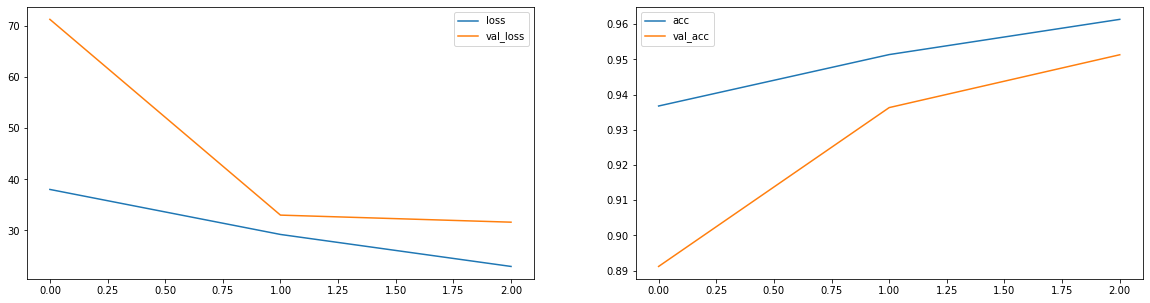

In [20]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history_list[7]['loss'], label="loss")
plt.plot(history_list[7]['val_loss'], label="val_loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_list[7]['acc'], label="acc")
plt.plot(history_list[7]['val_acc'], label="val_acc")
plt.legend()

plt.show()